# SoftVectorMachine, k-Neighbors, RF, LogisticRegression

### Processor
* VOC_duration : 1min
* Wash_Out : 8min

### Sensors
+ TGS : TGS2600, TGS2602, TGS2603, TGS2610, TGS2620
+ MQ : MQ2, MQ3, MQ4, MQ5, MQ6, MQ7, MQ8, MQ9, MQ135

### VOC
1. DPG ( 10%) + DPG (100%)
2. Actetic (10%) + DPG (99%)
3. Benzaldehyde (10%) + DPG (99%)
4. Keras (10%) + DPG (99%)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pymysql
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import cm
import seaborn as sns

import datetime, time
import os, sys
from pathlib import Path
from tqdm import tqdm
from datetime import datetime, timedelta

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz, _tree
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error, make_scorer
import graphviz

import statsmodels.api as sm
from scipy.stats import spearmanr

from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import MinMaxScaler

In [95]:
import warnings
warnings.filterwarnings(action='ignore')

In [5]:
plot_style = plt.style.available
# pd.options.display.float_format = '{:.5f}'.format
# pd.set_option('display.max_row', 500)
pd.set_option('display.max_rows', 500)

In [6]:
# plt.style.use('ggplot')
# plt.style.use('default')
# plt.style.use('fivethirtyeight')
plt.style.use('seaborn-paper')
# plt.style.use('seaborn-muted')

In [7]:
pd.set_option('display.expand_frame_repr', False)
np.random.seed(42)

In [8]:
PROJECT_DIR = Path('.')
DATA_DIR = Path(PROJECT_DIR, 'data')

In [9]:
print(PROJECT_DIR, DATA_DIR)

. data


## Soft Vector Machine analysis

### Data read

In [67]:
X = np.load("./data/npy/sensors_tgs_1sec_X_9min.npy")
y = np.load("./data/npy/sensors_tgs_1sec_y_9min.npy")

In [68]:
columns = ['TGS2600', 'TGS2602', 'TGS2603', 'TGS2620', 'TGS2610', 'TGS822',
           'CYCLE', 'VOC_CYCLE', 'UNIXSTAMP']
available_senosrs = ['TGS2600', 'TGS2602', 'TGS2603', 'TGS2620', 'TGS2610', 'TGS822']
non_available_senosrs = []
samples = np.unique(target_voc)

In [21]:
X[700]

array([0.42519994, 0.42519994, 0.42519994, ..., 0.35035616, 0.36976836,
       0.42519994])

### Soft Vector Machine

In [18]:
from sklearn.svm import SVC

In [19]:
svm_clf = SVC(random_state=42)
svm_clf.fit(X[:600], y[:600])  # y_train, not y_train_5

SVC(random_state=42)

In [23]:
svm_clf.predict([X[700]])

array(['Keras'], dtype='<U12')

In [26]:
voc_scores = svm_clf.decision_function([X[700]])
voc_scores.round(2)

array([[ 2.09, -0.25,  1.05,  3.24]])

In [27]:
class_id = voc_scores.argmax()
class_id

3

In [28]:
svm_clf.classes_

array(['Acetic', 'Benzaldehyde', 'DPG', 'Keras'], dtype='<U12')

In [29]:
svm_clf.classes_[class_id]

'Keras'

# Error Analysis

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict

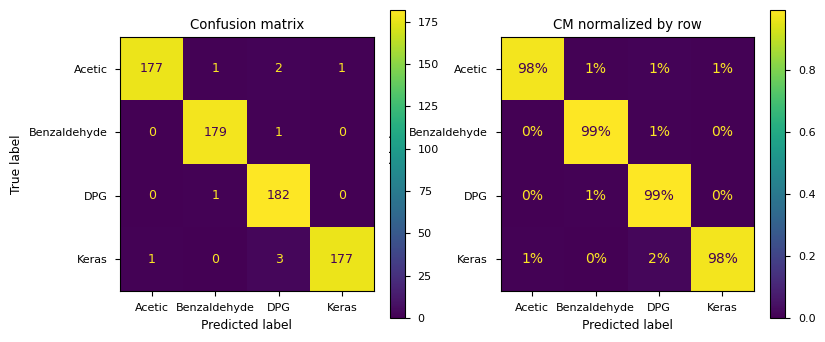

In [48]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=9)
ConfusionMatrixDisplay.from_predictions(y, 
                                        y_pred, 
                                        ax=axs[0])
axs[0].set_title("Confusion matrix")
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y, 
                                        y_train_pred, 
                                        ax=axs[1],
                                        normalize="true", 
                                        values_format=".0%")
axs[1].set_title("CM normalized by row")
plt.show()

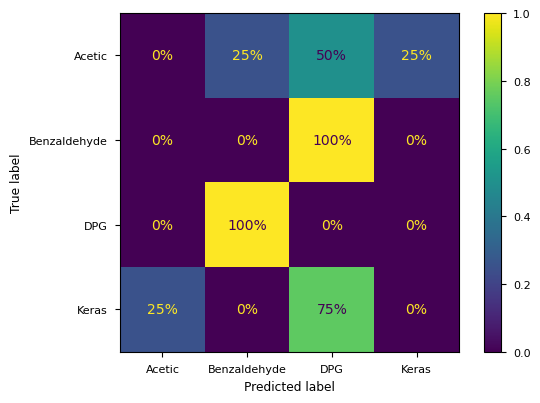

In [42]:
sample_weight = (y_train_pred != y)
plt.rc('font', size=10) 
ConfusionMatrixDisplay.from_predictions(y, y_pred,
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
plt.show()

# K-Neighbors analysis

In [49]:
from sklearn.neighbors import KNeighborsClassifier

In [50]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X[:600], y[:600])

baseline_accuracy = knn_clf.score(X[600:], y[600:])
baseline_accuracy

0.968

In [51]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5, 6]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5)
grid_search.fit(X[:600], y[:600])

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5, 6],
                          'weights': ['uniform', 'distance']}])

In [52]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'uniform'}

In [53]:
grid_search.best_score_

0.99

In [54]:
grid_search.best_estimator_.fit(X, y)
tuned_accuracy = grid_search.score(X, y)
tuned_accuracy

0.9862068965517241

### Random Forest

In [99]:
from sklearn.ensemble import RandomForestClassifier

In [100]:
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X[:600], y[:600])

baseline_accuracy = forest_clf.score(X[600:], y[600:])
baseline_accuracy

ValueError: Found array with 0 sample(s) (shape=(0, 6)) while a minimum of 1 is required by RandomForestClassifier.

### Logistic Regression

In [90]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [91]:
log_clf = LogisticRegression(max_iter=1000, random_state=42)
log_clf.fit(X[:600], y[:600])

LogisticRegression(max_iter=1000, random_state=42)

In [92]:
baseline_accuracy = log_clf.score(X[600:], y[600:])
print(baseline_accuracy)

0.968


In [93]:
score = cross_val_score(log_clf, X[:], y[:])
print(score.mean())

0.9875862068965517


In [86]:
from sklearn.metrics import precision_score, recall_score

y_pred = log_clf.predict(X[600:])
# print(y_pred)

print(f"Precision: {precision_score(y[600:], y_pred, average='weighted'):.2%}") # [None, 'micro', 'macro', 'weighted']
print(f"Recall: {recall_score(y[600:], y_pred, average='weighted'):.2%}") # [None, 'micro', 'macro', 'weighted']

Precision: 100.00%
Recall: 96.80%
